# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you pulled lyrics data on two artists. In this assignment we explore this data set and a pull from the now-defunct Twitter API for the artists Cher and Robyn.  If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Canvas. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
import matplotlib.pyplot as plt

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "C:/Users/lvand/OneDrive/Desktop/Applied Text Mining/M2/M1 Assignment Data/M1 Results/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [4]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True, top_n=10) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens) # total tokens
    num_unique_tokens = len(set(tokens)) # unique tokens
    lexical_diversity = num_unique_tokens / num_tokens if num_tokens > 0 else 0.0 # ratio of unique to total tokens
    num_characters = sum(len(token) for token in tokens) # total characters
    # Count the most common tokens
    token_counts = Counter(tokens)
    most_common_tokens = token_counts.most_common(top_n)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(f"The {num_tokens} most common tokens are:")
        for token, count in most_common_tokens:
            print(f"{token}: {count}")
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

In [5]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)


There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.
The 13 most common tokens are:
text: 3
here: 2
example: 2
is: 1
some: 1
with: 1
other: 1
in: 1
this: 1


Q: Why is it beneficial to use assertion statements in your code? 

A: In  this scenario, assertion statements are beneficial to detect potential errors in the values returned. An assertion guarantees that what is returned is true, otherwise errors will arise. Assertions are also good practice in general to assist in debugging scenarios and also properly document the coding as it is completed. In a way, assertions provide documentation by clarifying the values that are expected in the result. 

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [19]:
# Set your data location
data_location = "C:/Users/lvand/OneDrive/Desktop/Applied Text Mining/M2/M1 Assignment Data/M1 Results/"

# Subfolders for the lyrics and Twitter data
twitter_folder = os.path.join(data_location, "twitter/")
lyrics_folder = os.path.join(data_location, "lyrics/")

# Dictionary to store the lyrics data
lyrics_data = {}

# Read lyrics data
for artist_folder in os.listdir(lyrics_folder):
    artist_path = os.path.join(lyrics_folder, artist_folder)
    
    if os.path.isdir(artist_path):
        lyrics_data[artist_folder] = {}
        for song_file in os.listdir(artist_path):
            song_path = os.path.join(artist_path, song_file)
            with open(song_path, 'r', encoding='utf-8') as file:
                song_name = song_file.replace(".txt", "")
                lyrics_data[artist_folder][song_name] = file.read()

# Dictionary to store Twitter descriptions
twitter_data = defaultdict(list)

# Separate artists
artist_files = {
    'cher' : 'cher_followers_data.txt',
    'robyn' : 'robyn_followers_data.txt'
    }

# Read Twitter data
for artist, file_name in artist_files.items():
    artist_path = os.path.join(twitter_folder, file_name)
    
    if os.path.isfile(artist_path):
        with open(artist_path, 'r') as file:
            descriptions = file.readlines()
            twitter_data[artist] = [desc.strip() for desc in descriptions]

# Convert to DF
twitter = pd.DataFrame([
    {'artist': artist, 'Description': description}
    for artist, descriptions in twitter_data.items()
    for description in descriptions
])

# Example usage:
print(f"Lyrics data for artists: {list(lyrics_data.keys())[:2]}")
print(f"Twitter descriptions files: {list(artist_files)[:]}")

twitter.head()

Lyrics data for artists: ['cher', 'robyn']
Twitter descriptions files: ['cher', 'robyn']


,artist,Description
0,cher,screen_name\tname\tid\tlocation\tfollowers_cou...
1,cher,hsmcnp\tCountry Girl\t35152213\t\t1302\t1014
2,cher,horrormomy\tJeny\t742153090850164742\tEarth\t8...
3,cher,anju79990584\tanju\t1496463006451974150\t\t13\...
4,cher,gallionjenna\tJ\t3366479914\t\t752\t556\tcsu


## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [20]:
punctuation = set(punctuation) # speeds up comparison

In [21]:
# Function to clean and tokenize text
def clean_and_tokenize(text):
    # Remove punctuation and lowercase the text
    text = re.sub(r'[^\w\s]', '', text).lower()
    
    # Tokenize (split on whitespace)
    tokens = text.split()
    
    # Remove stopwords
    cleaned_tokens = [token for token in tokens if token not in sw]
    
    return cleaned_tokens

In [25]:
# create your clean twitter data here
clean_twitter_data = defaultdict(list)
for artist, descriptions in twitter_data.items():
    for description in descriptions:
        clean_twitter_data[artist].append(clean_and_tokenize(description))

In [26]:
# create your clean lyrics data here
clean_lyrics_data = {}
for artist, songs in lyrics_data.items():
    clean_lyrics_data[artist] = {}
    for song, lyrics in songs.items():
        clean_lyrics_data[artist][song] = clean_and_tokenize(lyrics)

## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

In [27]:
# Twitter data
artist = list(clean_twitter_data.keys())[0]
print(f"\nDescriptive stats for Twitter descriptions of {artist}:")
descriptive_stats(clean_twitter_data[artist][0])


Descriptive stats for Twitter descriptions of cher:
There are 7 tokens in the data.
There are 7 unique tokens in the data.
There are 64 characters in the data.
The lexical diversity is 1.000 in the data.
The 7 most common tokens are:
screen_name: 1
name: 1
id: 1
location: 1
followers_count: 1
friends_count: 1
description: 1


[7, 7, 1.0, 64]

In [28]:
# Lyrics data Descriptive Stats
for artist, songs in clean_lyrics_data.items():
    for song, tokens in songs.items():
        print(f"\nDescriptive statistics for {artist} - {song}:")
        descriptive_stats(tokens)


Descriptive statistics for cher - cher_88degrees:
There are 182 tokens in the data.
There are 82 unique tokens in the data.
There are 831 characters in the data.
The lexical diversity is 0.451 in the data.
The 182 most common tokens are:
cause: 9
hot: 8
im: 8
yeah: 8
88: 6
degrees: 5
deal: 5
time: 4
lord: 4
damn: 4

Descriptive statistics for cher - cher_adifferentkindoflovesong:
There are 137 tokens in the data.
There are 41 unique tokens in the data.
There are 691 characters in the data.
The lexical diversity is 0.299 in the data.
The 137 most common tokens are:
kind: 17
different: 16
love: 16
song: 16
ooh: 14
oh: 8
part: 3
everything: 3
higher: 3
world: 2

Descriptive statistics for cher - cher_afterall:
There are 120 tokens in the data.
There are 59 unique tokens in the data.
There are 603 characters in the data.
The lexical diversity is 0.492 in the data.
The 120 most common tokens are:
two: 8
weve: 6
back: 6
guess: 5
stops: 4
starts: 4
keep: 4
coming: 4
hearts: 4
angels: 4

Desc

Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: The stopwords includes common "filler" words such as the, and, to, etc. These words connect statements in lyrics and would most likely be the most common words in each song, which would provide a false sense of what the song actually is. 

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: I would have assumed that the lexical diversity would be on the higher side as each song has it's own meaning, story, and many words to be created by. Certain songs appear to have a relatively high diversity, suggesting that within an entire length of the song, outside of stopwords, there are many unique words. If we were to go beyond the most common tokens, it is likely that many words are only listed once throughout the song.


In [29]:
assert(emoji.is_emoji("❤️"))
assert(not emoji.is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [30]:
# Function to get emojis
def get_emoji_counts(texts):
    emoji_counts = Counter()
    for text in texts:
        emojis = [char for char in text if emoji.is_emoji(char)]
        emoji_counts.update(emojis)
    return emoji_counts

# Twitter emojis
for artist, descriptions in twitter_data.items():
    all_texts = ' '.join(descriptions)
    emoji_counts = get_emoji_counts([all_texts])
    print(f"Top 10 emojis for {artist}: {emoji_counts.most_common(10)}")

Top 10 emojis for cher: [('❤', 94506), ('🌈', 66291), ('♥', 48059), ('🏳', 47174), ('✨', 45846), ('🌊', 31234), ('💙', 31050), ('🏻', 25195), ('✌', 21963), ('💜', 21571)]


### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [31]:
# Function to get hashtags
def get_hashtag_counts(texts):
    hashtag_counts = Counter()
    for text in texts:
        hashtags = [word for word in text.split() if word.startswith('#')]
        hashtag_counts.update(hashtags)
    return hashtag_counts

# Twitter hashtages
for artist, descriptions in twitter_data.items():
    all_texts = ' '.join(descriptions)
    hashtag_counts = get_hashtag_counts([all_texts])
    print(f"Top 10 hashtags for {artist}: {hashtag_counts.most_common(10)}")

Top 10 hashtags for cher: [('#BLM', 8388), ('#Resist', 5095), ('#BlackLivesMatter', 4414), ('#resist', 3180), ('#FBR', 2834), ('#1', 2580), ('#blacklivesmatter', 2551), ('#TheResistance', 2501), ('#', 2205), ('#Resistance', 1538)]


### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [43]:
def tokenize_titles(titles):
    """Tokenize and clean song titles"""
    # Combine all titles into one string
    combined_titles = ' '.join(titles)
    # Use the same whitespace collapse and split function
    return tokenize_lyrics(combined_titles)

# Function to find the five most common words in song titles by artist
def most_common_words_by_artist(clean_lyrics_data):
    common_words = {}
    for artist, songs in clean_lyrics_data.items():
        titles = songs.keys()  # Get song titles
        tokens = tokenize_titles(titles)
        word_counts = Counter(tokens)
        # Get the five most common words
        common_words[artist] = word_counts.most_common(5)
    return common_words

# Get the most common words
common_words = most_common_words_by_artist(clean_lyrics_data)

# Print the results
for artist, words in common_words.items():
    print(f"Most common words in song titles for {artist}:")
    for word, count in words:
        print(f"  {word}: {count}")
    print()


Most common words in song titles for cher:
  cher_88degrees: 1
  cher_adifferentkindoflovesong: 1
  cher_afterall: 1
  cher_again: 1
  cher_alfie: 1

Most common words in song titles for robyn:
  robyn_88days: 1
  robyn_aintnothing: 1
  robyn_anytimeyoulike: 1
  robyn_babyforgiveme: 1
  robyn_beach2k20: 1



### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


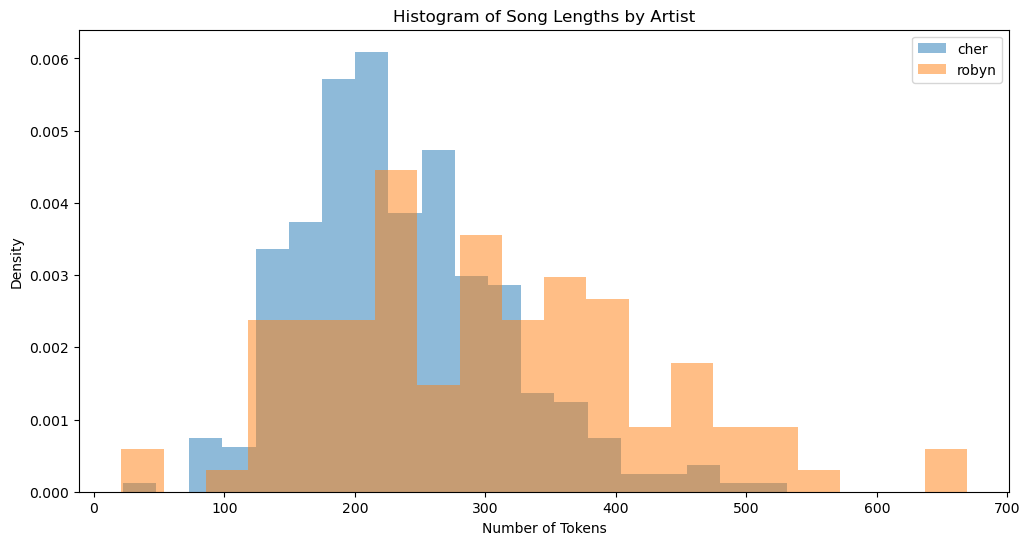

In [38]:
# Function to tokenize text
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

# Dictionary to store the lyrics data
song_lengths = defaultdict(list)

# Read lyrics data
for artist_folder in os.listdir(lyrics_folder):
    artist_path = os.path.join(lyrics_folder, artist_folder)
    
    if os.path.isdir(artist_path):
        for song_file in os.listdir(artist_path):
            song_path = os.path.join(artist_path, song_file)
            with open(song_path, 'r', encoding='utf-8', errors='replace') as file:
                song_name = song_file.replace(".txt", "")
                lyrics = file.read()
                token_count = len(tokenize(lyrics))
                song_lengths[artist_folder].append(token_count)
                
# Convert song lengths data into a DataFrame
df = pd.DataFrame({
    'artist': [artist for artist, lengths in song_lengths.items() for _ in lengths],
    'length': [length for lengths in song_lengths.values() for length in lengths]
})

# Plot histograms
plt.figure(figsize=(12, 6))
df.groupby('artist')['length'].plot(kind='hist', density=True, alpha=0.5, legend=True, bins=20)
plt.title('Histogram of Song Lengths by Artist')
plt.xlabel('Number of Tokens')
plt.ylabel('Density')
plt.show()

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: This regular expression matches any whitespace character, including spaces, tabs, newlines, and other Unicode whitespace characters. The '+' is a quantifier that means "one or more." It makes the regular expression match consecutive occurrences of whitespace characters.


In [32]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

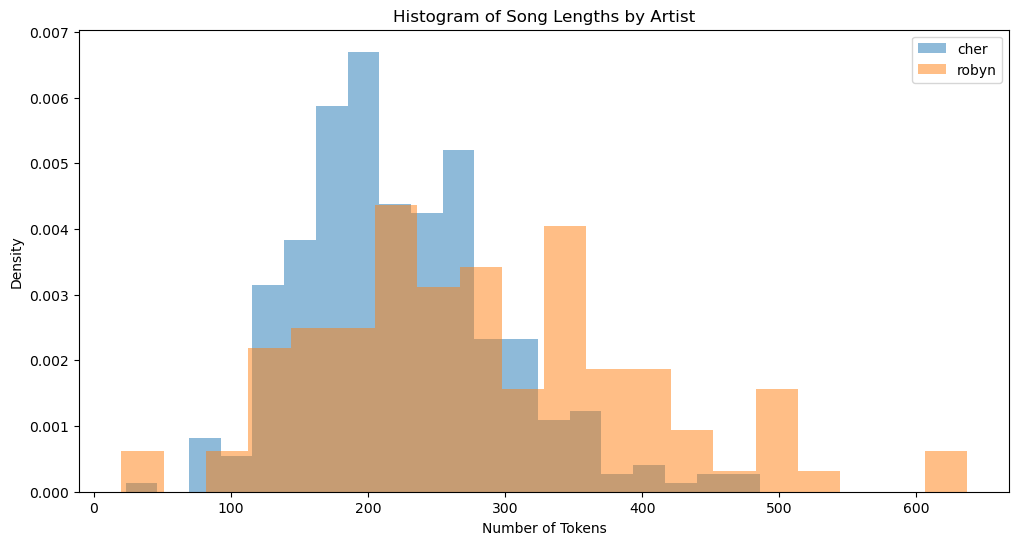

In [33]:
# Your lyric length comparison chart here. 
# Dictionary to store the tokenized lyrics data
song_lengths = defaultdict(list)

# Read lyrics data
for artist_folder in os.listdir(lyrics_folder):
    artist_path = os.path.join(lyrics_folder, artist_folder)
    
    if os.path.isdir(artist_path):
        for song_file in os.listdir(artist_path):
            song_path = os.path.join(artist_path, song_file)
            with open(song_path, 'r', encoding='utf-8', errors='replace') as file:
                lyrics = file.read()
                tokens = tokenize_lyrics(lyrics)
                token_count = len(tokens)
                song_lengths[artist_folder].append(token_count)

# Convert song lengths data into a DataFrame
df2 = pd.DataFrame({
    'artist': [artist for artist, lengths in song_lengths.items() for _ in lengths],
    'length': [length for lengths in song_lengths.values() for length in lengths]
})

# Plot histograms
plt.figure(figsize=(12, 6))
df2.groupby('artist')['length'].plot(kind='hist', density=True, alpha=0.5, legend=True, bins=20)
plt.title('Histogram of Song Lengths by Artist')
plt.xlabel('Number of Tokens')
plt.ylabel('Density')
plt.show()